<!-- # CNN autoencoder and Clustering from MTRX data

Use this notebook to load Scienta Omicron Matrix format SPM data and create standardised images for machine learning training and analysis. The code can generate both JPG image data, useful for manually checking the data, and windowed numpy data that can be loaded into ML models. 

The notebook then creates an autoencoder for training on a large dataset, followed by KMEANS clustering. 

**Author**: Steven R. Schofield  
**Created**: November, 2024 -->

# CASTEP output analysis
## Steven R. Schofield (Universtiy College London) May 2025

### Load required modules

In [38]:
import sys
from pathlib import Path

# Define candidate paths using Path objects
module_path_list = [
    Path('/Users/steven/academic-iCloud/Python/modules'),
    Path('/hpc/srs/Python/modules')
]

data_path_list = [
    Path('/Users/steven/academic-iCloud/Calculations/castep/Hydrogen_Bridge'),
    Path('/hpc/srs/Python-data')
]

# Resolve actual paths
module_path = next((p for p in module_path_list if p.exists()), None)
data_path = next((p for p in data_path_list if p.exists()), None)

# Check and report missing paths
if module_path is None:
    print("Error: Could not locate a valid module path.")
if data_path is None:
    print("Error: Could not locate a valid data path.")

if module_path is None or data_path is None:
    sys.exit(1)

# Add module_path to sys.path if needed
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))

# Print resolved paths
print(f"module_path = {module_path}")
print(f"data_path = {data_path}")


module_path = /Users/steven/academic-iCloud/Python/modules
data_path = /Users/steven/academic-iCloud/Calculations/castep/Hydrogen_Bridge


In [39]:
# # Ensure modules are reloaded 
%load_ext autoreload
%autoreload 2

# Import standard modules
import numpy as np
import pandas as pd

# Import custom module
import SRSCALCUTILS.castep_tools as ct

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Programme variable setup

In [40]:
# Parameters for windows creation
# General
job_folder = '1x6x8/1x6x8-821MP-SP-negative'
job_path = data_path / job_folder
verbose = False             # Set this True to print out more information

# Print resolved paths
print(f"job_path = {job_path}")

job_path = /Users/steven/academic-iCloud/Calculations/castep/Hydrogen_Bridge/1x6x8/1x6x8-821MP-SP-negative



                                               FILE: L8_clean.castep                                                
   PATH: /Users/steven/academic-iCloud/Calculations/castep/Hydrogen_Bridge/1x6x8/1x6x8-821MP-SP-negative/L8_clean   

Final enthalpy = -8363.55887 eV.


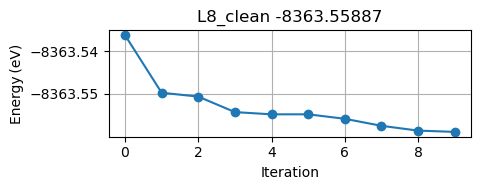

,cell parameter,Value
0,ax,3.866835
1,ay,23.201008
2,az,25.93706
3,nx,1
4,ny,6
5,nz,err
6,alpha,90.0
7,beta,90.0
8,gamma,90.0


In [ ]:
castep_paths = ct.find_all_castep_files(job_path)

for castep_path in castep_paths:
    # Header and error information
    ct.print_file_info(castep_path)
    #ct.extract_warnings(castep_path,verbose=True)

    # Energy convergence
    convergence = ct.extract_LBFGS_energies(castep_path)
    final_enthalpy = ct.extract_LBFGS_final_enthalpy(castep_path)
    print('Final enthalpy = {} eV.'.format(final_enthalpy))
    ct.plot_energy_vs_iteration(convergence, title=castep_path.stem+' '+str(final_enthalpy),figsize=(5,2))
    
    # Unit cell parameters
    cell = ct.extract_lattice_parameters(castep_path,a0=3.8668346, vac=15.0)
    cell_df = pd.DataFrame(cell.items(), columns=["cell parameter", "Value"])
    display(cell_df) 

    break

    
    
    

In [ ]:
#!/Users/steven/opt/anaconda3/bin/python

import os
import re
import numpy as np

import os
from pathlib import Path


def natural_sort_key(s):
    """
    A sort key function for natural (human) sorting. It converts the string into a list of strings and integers.
    """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def extract_info_from_castep(file_path):
    enthalpy = 'N/A'
    total_time_hours = 'N/A'
    cut_off_energy = 'N/A'  # Initialize the variable
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    for line in reversed(lines):
        if "LBFGS: Final Enthalpy" in line and enthalpy == 'N/A':
            parts = line.split()
            enthalpy = parts[4]
        elif "Total time" in line and total_time_hours == 'N/A':
            parts = line.split('=')
            total_time_seconds = float(parts[1].split()[0])
            total_time_hours = total_time_seconds / 3600
        elif "Calculating total energy with cut-off of" in line:
            cut_off_energy = re.findall(r"\d+\.\d+", line)[0]  # Extract the numerical value

        if all(value != 'N/A' for value in [enthalpy, total_time_hours, cut_off_energy]):
            break

    return enthalpy, total_time_hours, cut_off_energy  # Return the extracted cut-off energy


def extract_kpoint_from_cell(file_path):
    """
    Extracts k-point mesh from a .cell file and returns the values as three separate variables: kx, ky, kz
    """
    kx, ky, kz = 'N/A', 'N/A', 'N/A'
    with open(file_path, 'r') as file:
        for line in file:
            if "kpoint_mp_grid" in line:
                parts = line.split(':')
                kpoints = parts[1].strip().split()
                if len(kpoints) == 3:
                    kx, ky, kz = kpoints
                break
    return kx, ky, kz

def extract_params_from_param(file_path):
    """
    Extracts cut off energy and spin polarisation status from a .param file
    """
    cut_off_energy = 'N/A'
    spin_polarised = 'N/A'
    charge = 'N/A'
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if "cut_off_energy" in line:
                cut_off_energy = line.split(':')[1].strip()
            elif "spin_polarised" in line:
                spin_polarised = line.split(':')[1].strip()
            elif "charge" in line:
                charge = line.split(':')[1].strip()
    return cut_off_energy, spin_polarised, charge





def process_directories(job_path):
    """
    Processes all immediate subdirectories of job_path, extracting CASTEP-related info.
    
    Parameters:
        job_path (str or Path): Path to the directory containing job subfolders.
    """
    job_path = Path(job_path)
    directories = [d for d in job_path.iterdir() if d.is_dir()]
    directories = sorted(directories, key=lambda p: natural_sort_key(p.name))

    results = []

    for directory in directories:
        castep_path = None
        cell_path = None
        param_path = None
        out_cell_path = None
        usp_file_path = None

        for file in directory.iterdir():
            if file.name.endswith('-out.cell'):
                out_cell_path = file
            elif file.name.endswith('.castep'):
                castep_path = file
            elif file.name.endswith('.cell'):
                cell_path = file
            elif file.name.endswith('.param'):
                param_path = file

        usp_files = list(directory.glob('Si*.usp'))
        usp_file_path = usp_files[0].name if usp_files else 'N/A'

        if castep_path:
            enthalpy, total_time_hours, cut_off_energy = extract_info_from_castep(castep_path)
            total_time_hours = round(total_time_hours, 4) if total_time_hours != 'N/A' else 'N/A'
            kx, ky, kz = extract_kpoint_from_cell(cell_path) if cell_path else ('err', 'err', 'err')
            ax, ay, az, nx, ny, nz = extract_lattice_params(out_cell_path) if out_cell_path else ('err', 'err', 'err', 'err', 'err', 'err')
            _, spin_polarised, charge = extract_params_from_param(param_path) if param_path else ('err', 'N/A', 'N/A')

            enthalpy = f"{float(enthalpy):.6f}" if enthalpy != 'N/A' else 'N/A'

            results.append([
                directory.name, usp_file_path, total_time_hours,
                ax, ay, az, nx, ny, nz, kx, ky, kz,
                cut_off_energy, spin_polarised, charge, enthalpy
            ])

    # Print output header
    header = [
        "Directory", "Si usp File", "Time(h)", "ax", "ay", "az", "nx", "ny", "nz",
        "kx", "ky", "kz", "cut", "spin", "charge", "Enthalpy(eV)"
    ]
    format_str = "{:<20} {:<20} {:<10} {:<10} {:<10} {:<10} {:<5} {:<5} {:<5} {:<5} {:<5} {:<5} {:<8} {:<7} {:<7} {:<20}"

    print(format_str.format(*header))
    for result in results:
        print(format_str.format(*result))


In [76]:
process_directories(job_path)

Directory            Si usp File          Time(h)    ax         ay         az         nx    ny    nz    kx    ky    kz    cut      spin    charge  Enthalpy(eV)        
L8_1di               Si_EXT_PBE_OTF.usp   2.5391     3.866835   23.201008  25.93706   1     6     8     8     2     1     800.000  true    -1      -8496.089470        
L8_3x1               Si_EXT_PBE_OTF.usp   9.4557     3.866835   23.201008  25.93706   1     6     8     8     2     1     800.000  true    -1      -8496.179060        
L8_clean             Si_EXT_PBE_OTF.usp   5.7342     3.866835   23.201008  25.93706   1     6     8     8     2     1     800.000  true    -1      -8363.558870        
L8_DB                Si_C19_PBE_OTF.usp   9.7595     3.866835   23.201008  25.93706   1     6     8     8     2     1     800.000  true    -1      -8447.713130        
L8_di                Si_EXT_PBE_OTF.usp   7.5937     3.866835   23.201008  25.93706   1     6     8     8     2     1     800.000  true    -1      -8558.205890 

In [1]:
import dft
print(dir(dft))


ModuleNotFoundError: No module named 'dft'